# Clean 100 frames

In [32]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from IPython.display import display, clear_output
import re
import json
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Function to save checkpoint
def save_checkpoint(subject_id, camera, batch_index, checkpoint_file='checkpoint.json'):
    checkpoint_data = {
        'subject_id': subject_id,
        'camera': camera,
        'batch_index': batch_index
    }
    with open(checkpoint_file, 'w') as f:
        json.dump(checkpoint_data, f)

In [3]:
# Function to load checkpoint
def load_checkpoint(checkpoint_file='checkpoint.json'):
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'r') as f:
            return json.load(f)
    return None

In [33]:
# Function to display the images and let the user decide if they want to keep or remove
def display_images(subject_img, frame_images):
    rows = (len(frame_images) // 10) + (1 if len(frame_images) % 10 != 0 else 0)
    fig, axes = plt.subplots(rows + 1, 10, figsize=(15, rows * 1.5))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    ax = axes[0, 0]
    ax.imshow(subject_img)
    ax.axis('off')
    ax.set_title("Subject Image")

    for i in range(1, rows + 1):
        for j in range(10):
            idx = (i - 1) * 10 + j
            if idx < len(frame_images):
                ax = axes[i, j]
                ax.imshow(frame_images[idx])
                ax.axis('off')
                ax.text(0.95, 0.05, str(idx + 1), color='white', fontsize=10, transform=ax.transAxes, ha='right', va='bottom', weight='bold')
    plt.show()

In [5]:
# Function to remove frames based on user-defined range
def remove_images_in_range(batch, user_range):
    """Remove frames based on user input range (e.g., 1-5, 25-45)."""
    try:
        # Parse the range input
        if '-' in user_range:
            start, end = map(int, user_range.split('-'))
            # Make sure start and end are within bounds
            if start < 1 or end > len(batch):
                print(f"Invalid range! Valid range is 1-{len(batch)}.")
                return []
            # Return the frames to remove, converting to 0-based index
            return [batch[i-1] for i in range(start, end+1)]
        else:
            print("Invalid range format. Please use the format 'start-end'.")
            return []
    except ValueError:
        print("Error: Invalid range format. Please use 'start-end'.")
        return []

In [26]:
# Function to parse user input for ranges or specific numbers
def parse_remove_input(user_input, total_frames):
    frames_to_remove = set()
    try:
        if user_input.startswith('[') and user_input.endswith(']'):
            range_input = user_input[1:-1]
            ranges = range_input.split(',')
            start, end = map(int, ranges)
            if 1 <= start <= end <= total_frames:
                frames_to_remove = set(range(start, end + 1))
            else:
                print("Invalid range, skipping removal.")
        else:
            specific_frames = user_input.split(',')
            frames_to_remove = set(int(frame.strip()) for frame in specific_frames if frame.strip().isdigit())
            frames_to_remove = {frame for frame in frames_to_remove if 1 <= frame <= total_frames}
    except ValueError:
        print("Invalid input format. Please enter a valid range or specific frame numbers.")
    return frames_to_remove

In [34]:
# Function to process the frames and allow user input
def process_frames(subject_id, subject_img, frames_dir, history_stack, checkpoint):
    camera_dirs = [d for d in os.listdir(frames_dir) if os.path.isdir(os.path.join(frames_dir, d))]
    for camera in camera_dirs:
        camera_frame_dir = os.path.join(frames_dir, camera, "frames")
        frame_files = [f for f in os.listdir(camera_frame_dir) if f.endswith('.png')]
        # random.shuffle(frame_files)
        batch_size = 50
        start_batch = checkpoint.get('batch_index', 0) if checkpoint and checkpoint.get('camera') == camera else 0
        for i in range(start_batch, len(frame_files), batch_size):
            batch = frame_files[i:i+batch_size]
            frame_images = [mpimg.imread(os.path.join(camera_frame_dir, frame)) for frame in batch]
            display_images(subject_img, frame_images)
            while True:
                user_input = input(f"Do you want to keep these {len(batch)} images, go back, or remove specific frames? (k/b/[frames]): ")
                clear_output(wait=True)  # Clear the output of the cell
                if user_input == 'k':
                    print("Keeping images...")
                    history_stack.append(('k', batch))
                    save_checkpoint(subject_id, camera, i // batch_size)
                    break
                elif user_input == 'b':
                    if history_stack:
                        last_action = history_stack.pop()
                        print("Going back to previous iteration...")
                        if last_action[0] == 'r':
                            frames_to_restore = last_action[2]
                            for frame in frames_to_restore:
                                frame_path = os.path.join(camera_frame_dir, frame)
                                print(f"Restoring frame: {frame}")
                        display_images(subject_img, frame_images)
                    else:
                        print("No action to go back to.")
                else:
                    frames_to_remove = parse_remove_input(user_input, len(batch))
                    if frames_to_remove:
                        print(f"Removing frames: {frames_to_remove}")
                        for frame_idx in frames_to_remove:
                            frame = batch[frame_idx - 1]
                            frame_path = os.path.join(camera_frame_dir, frame)
                            if os.path.exists(frame_path):
                                print('Remove frame: ', frame_path)
                                os.remove(frame_path)
                                
                        history_stack.append(('r', batch, frames_to_remove))
                        save_checkpoint(subject_id, camera, i // batch_size)
                        break
                    else:
                        print("Invalid input, please enter 'k', 'b' or valid frame numbers/ranges.")

In [28]:
# Function to process each subject
def process_subjects(first_root, second_root, checkpoint):
    image_files = [f for f in os.listdir(first_root) if f.endswith('.png')]
    subject_ids = set()
    for image_file in image_files:
        match = re.match(r"([a-zA-Z0-9_-]+)_set1_wb0_1_0.rs-image-5.png", image_file)
        if match:
            subject_ids.add(match.group(1))
    print('Found subject IDs: ', subject_ids)
    history_stack = []
    start_subject = checkpoint.get('subject_id') if checkpoint else None
    resume = False
    for subject_id in subject_ids:
        if start_subject and subject_id != start_subject and not resume:
            continue
        resume = True
        subject_img_path = os.path.join(first_root, f"{subject_id}_set1_wb0_1_0.rs-image-5.png")
        if os.path.exists(subject_img_path):
            subject_img = mpimg.imread(subject_img_path)
        else:
            print(f"Subject image for {subject_id} not found in {first_root}. Skipping...")
            continue
        subject_frame_dir = os.path.join(second_root, subject_id)
        if os.path.exists(subject_frame_dir):
            process_frames(subject_id, subject_img, subject_frame_dir, history_stack, checkpoint)
        else:
            print(f"Frames for subject {subject_id} not found in {second_root}. Skipping...")


Removing frames: {1, 3, 5, 7, 8, 10, 12, 13, 15, 19, 24, 25, 26, 28, 29, 36, 41, 42, 43, 44, 49}
Remove frame:  output/K22602/G318/frames/frame_0967.png
Remove frame:  output/K22602/G318/frames/frame_8873.png
Remove frame:  output/K22602/G318/frames/frame_0593.png
Remove frame:  output/K22602/G318/frames/frame_0548.png
Remove frame:  output/K22602/G318/frames/frame_1681.png
Remove frame:  output/K22602/G318/frames/frame_8405.png
Remove frame:  output/K22602/G318/frames/frame_8418.png
Remove frame:  output/K22602/G318/frames/frame_8309.png
Remove frame:  output/K22602/G318/frames/frame_1845.png
Remove frame:  output/K22602/G318/frames/frame_0839.png
Remove frame:  output/K22602/G318/frames/frame_8346.png
Remove frame:  output/K22602/G318/frames/frame_2234.png
Remove frame:  output/K22602/G318/frames/frame_2589.png
Remove frame:  output/K22602/G318/frames/frame_2804.png
Remove frame:  output/K22602/G318/frames/frame_1083.png
Remove frame:  output/K22602/G318/frames/frame_0206.png
Remove 

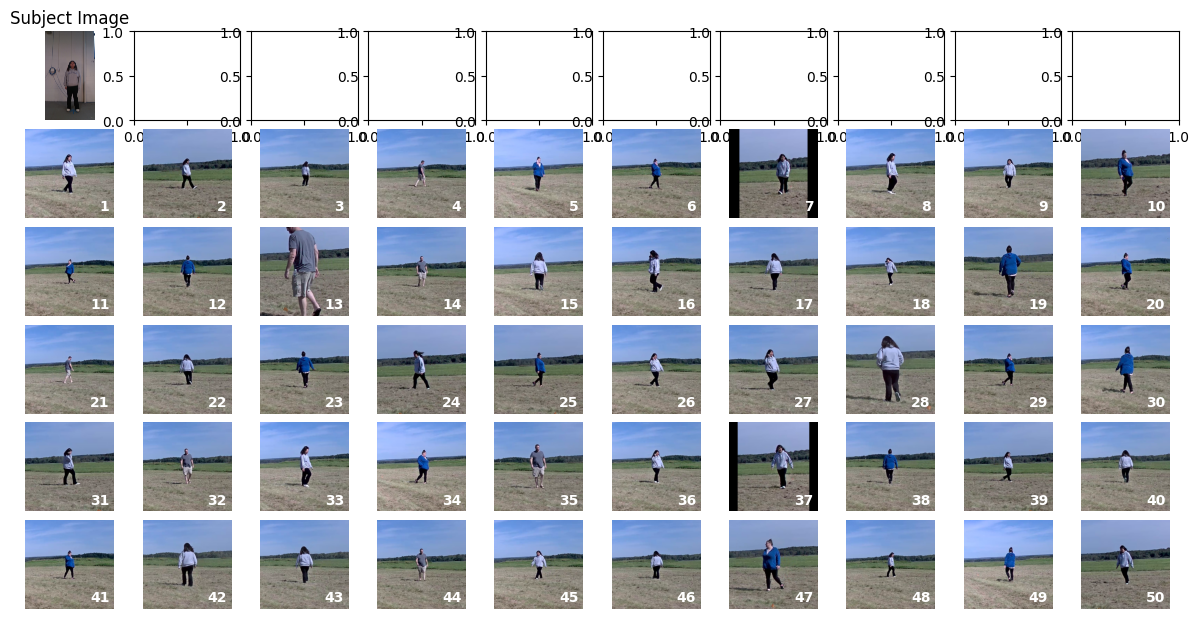

KeyboardInterrupt: Interrupted by user

In [35]:

# Example usage:
first_root = '/home/caio.dasilva/datasets/brc2_rotate/'  # The first directory where the subject images are located
second_root = 'output/'  # The second directory with the frames organized by subject/camera/frames

# Load checkpoint if available
checkpoint = load_checkpoint()

# Run the process
process_subjects(first_root, second_root, checkpoint)
print('Done')
